<a href="https://colab.research.google.com/github/khs5696/AI504/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import copy
import math
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from itertools import chain
from abc import ABC

Preprocessing
- Tokenize include symbol (. , ! ?)

In [2]:
def tokenize(input):
  input = input.replace('.', ' . ')
  input = input.replace(',', ' , ')
  input = input.replace('!', ' ! ')
  input = input.replace('?', ' ? ')
  token = input.split()

  if not isinstance(token, list):
    raise TypeError("Invalid type for tokens.")

  return token

Build vocabulary
- Estimate the 'frequency' of each word and index.
- Rare words can cause over-fitting, so we will replace these words to 'UNK' tokens.

In [3]:
'''
    Arguments:
    sentences -- The list of sentence to build vocab. Each sentence is a list of words.
    min_freq -- The minimum frequency of a word. Words that have a frequency less than a threshold are excluded from a vocabulary.

    Return:
    idx2word -- A dictionary which maps an index to the word , key : index (int), value : word (str)   ex) {0:'<PAD>', 1:'<UNK>', 2:'This', 3:'sentence', ...}
    word2idx -- A dictionary which maps the word to an index, key : word (str), value : index (int)   ex) {'<PAD>': 0, '<UNK>': 1, 'This': 2, 'sentence': 3, ...}
    word_freq -- A dictionary which maps the word to its frequency, key : word (str), value : index (int)
'''
def build_vocab(sentences, min_freq):
  idx2word = {0:'<UNK>'}
  word2idx = {'<UNK>':0}

  full_sentence = []
  for sentence in sentences:
    full_sentence.extend(sentence)
  word_freq = Counter(full_sentence)

  rare_freq = 0
  for word in word_freq.copy().keys():
    if word_freq[word] < min_freq:
      rare_freq += word_freq.pop(word)
    else:
      index = len(idx2word)
      idx2word[index] = word
      word2idx[word] = index
  word_freq['<UNK>'] = rare_freq

  return idx2word, word2idx, word_freq

Prepare Skip-gram dataset(DataLoader)
- Skip-gram with Negative Sampling(SGNS)는 [중심단어] - [주변단어 or Negative Sample] 형태로 이뤄져있는 데이터셋을 사용한다.

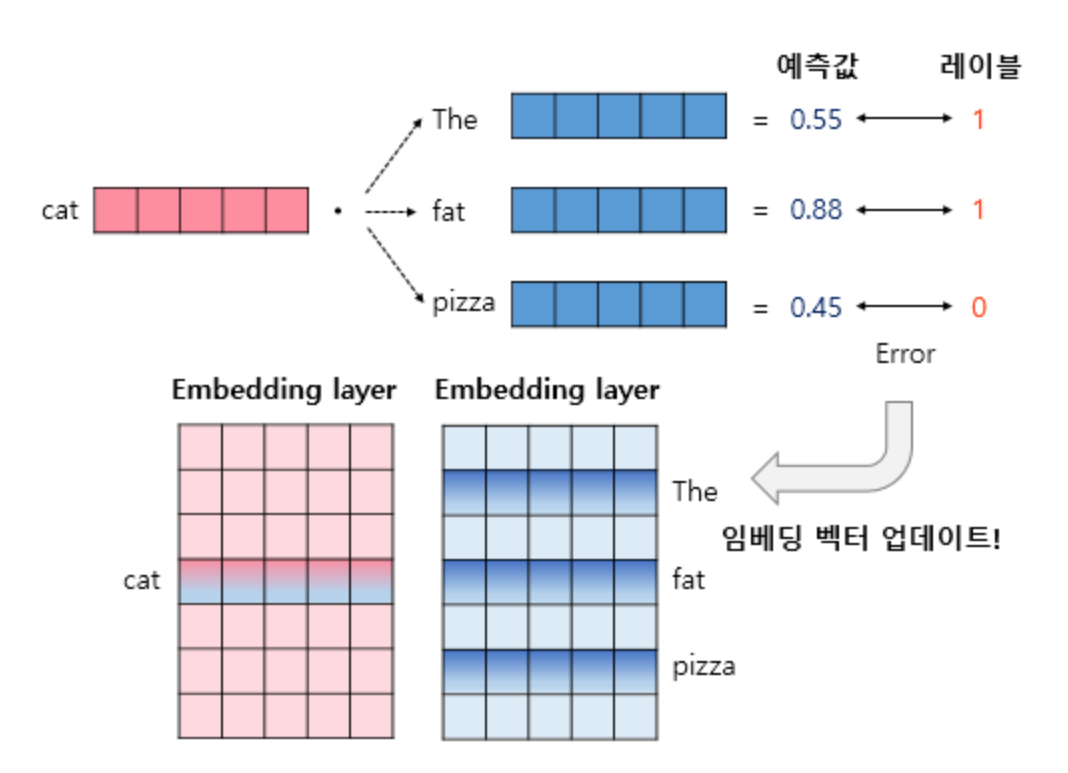

i) Preparing training data
- Function which returns a (center_word, surrounding_words) pair from tokens of a sentence for Skip-Gram.



In [4]:
"""
Argument:
  tokens -- A sentence where the center word and the surrounding words come from (List[str])
  win_size -- context window size (int)

Return:
  window_pairs -- List of (center word, surrounding_word) pairs. (List[Tuple])
                  For example, # ["Jhon's", "book", "is", "not", "popular"] w/ win_size 2, -> [("Jhon's", 'book'), ("Jhon's", 'is'), ('book', "Jhon's"), ('book', 'is'), ('book', 'not'), ('is', "Jhon's"), ('is', 'book'), ...]
"""
def get_window_pairs(tokens, win_size = 4):
  window_pairs = []

  for center in range(len(tokens)):
    for left in range(-win_size, 0, 1):
      if left + center >= 0:
        window_pairs.append((tokens[center], tokens[left + center]))
    for right in range(1, win_size+1, 1):
      if right + center < len(tokens):
        window_pairs.append((tokens[center], tokens[right + center]))

  return window_pairs

ii) Preparing Custom Dataset (DataLoader)
- Negative sampling to improve skip-gram
- 전체 단어 집합이 아니라 일부 단어 집합에만 집중하기 위해

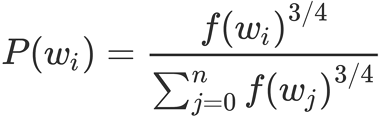

In [5]:
# Inherit 'Dataset' class to build custom dataset.
class SkipgramDataset(Dataset):
    PAD_TOKEN = '<PAD>'
    PAD_TOKEN_IDX = 0
    UNK_TOKEN = '<UNK>'
    UNK_TOKEN_IDX = 1

    def __init__(self, document, window_size, min_freq, negative_sampling=False):
        self._window_size = window_size

        # 전체 문서(document)를 토큰화 → build_vocab()
        tokens = [tokenize(line.strip().lower()) for line in document]
        idx2word, word2idx, word_freq = build_vocab(tokens, min_freq=min_freq)

        self._idx2word = idx2word
        self._word2idx = word2idx
        self._word_freq = word_freq

        if negative_sampling:
          self.negative_sample_table = list()
          self.prepare_negative_samples(power = 0.75)

        self.prepare_data(tokens, negative_sampling)

    @property
    def n_tokens(self):
        return len(self._idx2word)

    ''' negative sampling을 위한 negative_sample_table 생성 '''
    def prepare_negative_samples(self, power):
        """
        Arguments:
        power -- (int)
        _word_freq -- A dictionary which maps the word to its frequency, key : word (str), value : index (int)

        Return:
        self.negative_sample_table -- 1D numpy array which is filled with the vocabulary index. We desire that the random sampling from this array is equivalent to sample the index from the distribution above.
        """
        ############################ TODO : implement the negative sampler##################################
        # 전체 단어에서 어떤 단어가 Negative Sampling으로 뽑힐 확률
        # = (어떤 단어의 frequency ^ 0.75) / (모든 단어의 frequency ^ 0.75)
        vocab_size = len(self._word_freq)
        power = 0.75
        norm = sum([math.pow(count, power) for count in self._word_freq.values()]) # Normalizing constant

        table_size = int(1e6) # Length of the unigram table
        table = np.zeros(table_size, dtype=np.int32)

        p = 0 # Cumulative probability
        i = 0
        # 어떤 단어가 Negative sample로 뽑힐 누적 확률에 따라 index가 담긴 table을 생성한다.
        for word, count in self._word_freq.items():
            p += float(math.pow(count, power))/norm
            while i < table_size and float(i) / table_size < p:
                table[i] = self.word2idx(word)
                i += 1
        self.negative_sample_table = table
        ######################################################################################################

    ''' 위에서 만든 negative_sample_table에서 무작위로 K개를 샘플링 '''
    def negative_sampler(self, K=5):
        indices = np.random.randint(low=0, high=len(self.negative_sample_table), size=K)
        return [self.negative_sample_table[i] for i in indices]

    ''' Document를 구성하는 각 단어에 대해 주변 단어 (+ Negative Sample)을 제공한다.'''
    def prepare_data(self, tokens, negative_sampling=False):
      self.features = list()
      # feature : 특정 문장(tokenized_sentence)를 구성하는 각 단어(token)에 대해
      # skip-gram (center word index, surrounding word index) list를 반환한다.
      # ex. [(1, 2), (1, 3), (1, 4), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), ... ]
      for tokenized_sentence in tokens:
          feature = [(self.word2idx(x),self.word2idx(y)) for x,y in get_window_pairs(tokenized_sentence, self._window_size)]
          # negative sampling을 수행하는 경우
          # feature : (center word index, [surrounding word index, 5개의 negative sampling])
          # ex. [(1, [2, 40, 10, 28, 1, 22]), (1, [3, 20, 3, 6, 8, 23]), (1, [4, 35, 3, 36, 26, 5]), ... ]
          if negative_sampling:
            feature = list()
            for center, surrounding in get_window_pairs(tokenized_sentence, self._window_size):
              negative_sample = self.negative_sampler(K=5)
              feature.append((self.word2idx(center), [self.word2idx(surrounding),]+ negative_sample))
          self.features.append(feature)
      self.features = list(chain(*self.features))

    def idx2word(self, index: int) -> str:
        return self._idx2word[index]

    def word2idx(self, word: str) -> int:
        if word in self._word2idx:
            return self._word2idx[word]
        else:
            return self._word2idx["<UNK>"]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[i]

Skip-gram without Negative Sampling
- The objective function is the softmax over a center word and surrounding words

![picture](https://drive.google.com/uc?id=1Krmu4OoPEwnkhaBSsShEMDzEWuMZvVxy)

In [6]:
''' 각 token에 대해 embedding vector를 반환하는 lookup table을 생성한다 '''
class Word2Vec(torch.nn.Module, ABC):
    def __init__(self, n_tokens, embedding_dimension):
        super().__init__()
        # nn.Parameter : 자동으로 미분이 되는 parameter를 지정한다. → (token의 개수) x (embedding vector의 차원)
        self.input_embedding = torch.nn.Parameter(torch.empty([n_tokens, embedding_dimension]), requires_grad=True)
        self.output_embedding = torch.nn.Parameter(torch.empty([n_tokens, embedding_dimension]), requires_grad=True)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.normal_(self.input_embedding.data)
        torch.nn.init.normal_(self.output_embedding.data)

    def forward(self, input_feature):
        """
        Arguments:
        input_embedding -- Embedding matrix for the input, the center word in our case.
        output_embedding -- Embedding matrix for the ouput, the surrounding words in our case.
        input_features -- Tuple;
                          ( center word indeces, shape: [batch_size]
                            surrounding word indeces, shape: [batch_size] )
        Return: loss
        """
        ############################################################################
        ## TODO : Define loss function
        input_idx, target_idx = input_feature
        input_embed = self.input_embedding[input_idx]   # center word에 대한 embedding vector : (batch_size x embedding_dimension)
        # input_embed를 output_embedding(lookup table)에 내적하여 각 단어가 이웃할 확률을 예측 : (batch_size x n_tokens)
        logit = torch.einsum('ik,jk->ij',[input_embed, self.output_embedding])
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logit, target_idx)              # 예측된 주변 단어(logit)와 실제 주변 단어 간의 손실 계산
        ############################################################################
        return loss

Test the model

In [7]:
document = [
            "Word2vec is a technique for natural language processing published in 2013.",
            "The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text.",
            "Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence."
            ]

In [8]:
# Prepare data
db = SkipgramDataset(document, window_size=3, min_freq=1)
data_loader = DataLoader(db, batch_size=4)

# Prepare model & optimizer
model = Word2Vec(n_tokens=len(db._idx2word),embedding_dimension=64)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(10):
  epoch_loss = 0
  for batch in data_loader:       # batch : (center word list, surrounding word list)
    optimizer.zero_grad()
    # forward
    loss = model(batch)
    epoch_loss += loss.item()
    # backward
    loss.backward()
    optimizer.step()
  print(f"epoch: {epoch}, loss: {epoch_loss}")

epoch: 0, loss: 1240.9285230636597
epoch: 1, loss: 1222.451714515686
epoch: 2, loss: 1204.8976230621338
epoch: 3, loss: 1188.3821287155151
epoch: 4, loss: 1172.752568244934
epoch: 5, loss: 1157.732626914978
epoch: 6, loss: 1143.1170063018799
epoch: 7, loss: 1128.8029594421387
epoch: 8, loss: 1114.749080657959
epoch: 9, loss: 1100.940863609314


Skip-gram with Negative Sampling
- The objective function is the softmax over the positive sample and negative samples.

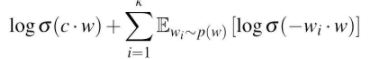



In [27]:
class NCEWord2Vec(torch.nn.Module, ABC):
    def __init__(self, n_tokens, embedding_dimension):
        super().__init__()
        self.input_embedding = nn.Embedding(n_tokens, embedding_dimension)
        self.output_embedding = nn.Embedding(n_tokens, embedding_dimension)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.normal_(self.input_embedding.weight.data)
        torch.nn.init.normal_(self.output_embedding.weight.data)

    def forward(self, input_feature):
        """
        Arguments:
        input_embedding -- Embedding matrix for the input, the center word in our case.
        output_embedding -- Embedding matrix for the ouput, the surrounding words in our case.
        input_feautres -- Tuple;
                          ( center word indeces, shape: [batch_size]
                            surrounding word & negative sample indeces, shape: [batch_size, K] )
        Return: loss
        """
        ############################################################################
        ## TODO : Define loss function
        input_idx, negative_sample_idx = input_feature
        input_embed = self.input_embedding(input_idx) # (batch_size x embedding_dimension)
        # output_embedding(negative_sample_idx) : '주변 단어 + Negative Sample'에 대한 output embedding vector
        # (batch_size x K x embedding_dimension)
        # 중심 단어의 embedding vector와 내적할 경우 0을 반환해야 한다. : (batch_size, K)
        logit = torch.einsum('ik,ijk->ij',[input_embed, self.output_embedding(negative_sample_idx)])
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logit, torch.tensor([0]*input_idx.size(0)))
        ############################################################################
        return loss

In [29]:
# Prepare data
db = SkipgramDataset(document, window_size=3, min_freq=1, negative_sampling=True)
data_loader = DataLoader(db, batch_size=4)
# Prepare model & optimizer
model = NCEWord2Vec(n_tokens=len(db._idx2word),embedding_dimension=64)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(10):
  epoch_loss = 0
  for batch in data_loader:       # (중심 단어 index, [주변 단어 index + Negative Sample index])
    # batchfy negative samples
    batch[-1] = torch.stack(batch[-1]).transpose(0,1)
    optimizer.zero_grad()
    # forward
    loss = model(batch)
    epoch_loss += loss.item()
    # backward
    loss.backward()
    optimizer.step()
  print(f"epoch: {epoch}, loss: {epoch_loss}")

epoch: 0, loss: 645.2548248767853
epoch: 1, loss: 641.1095895767212
epoch: 2, loss: 636.9951441287994
epoch: 3, loss: 632.9112191200256
epoch: 4, loss: 628.8574860095978
epoch: 5, loss: 624.8336246013641
epoch: 6, loss: 620.8393278121948
epoch: 7, loss: 616.8742213249207
epoch: 8, loss: 612.9379632472992
epoch: 9, loss: 609.030181646347
